In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-09-21 02:37:02--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv.1’

housing.csv.1       100%[===================>]   1.36M  --.-KB/s    in 0.03s   

2023-09-21 02:37:02 (44.5 MB/s) - ‘housing.csv.1’ saved [1423529/1423529]



### **EDA**

Load the data.
Look at the median_house_value variable. Does it have a long tail?

In [71]:
df=pd.read_csv("housing.csv")

In [72]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<Axes: xlabel='median_house_value', ylabel='Count'>

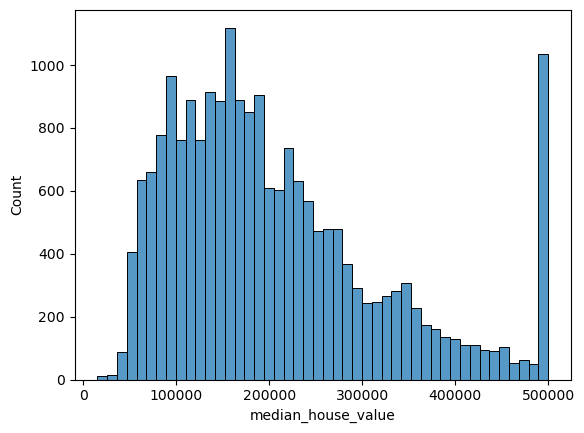

In [73]:
sns.histplot(df.median_house_value)

This graph doesn't show that the variable 'median_house_value' have a long tail.

In [74]:
price_logs=np.log1p(df.median_house_value)

<Axes: xlabel='median_house_value', ylabel='Count'>

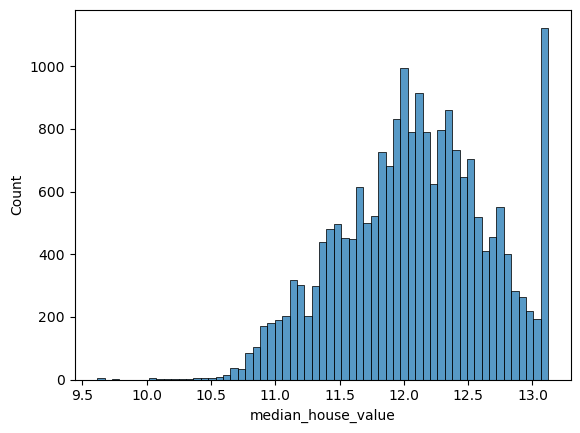

In [75]:
sns.histplot(price_logs)

In [98]:
df=df[(df.ocean_proximity=="<1H OCEAN") | (df.ocean_proximity=="INLAND")]

In [99]:
df.ocean_proximity.value_counts()

<1H OCEAN    9136
INLAND       6551
Name: ocean_proximity, dtype: int64

### **Question 1**

There's one feature with missing values. What is it?

In [102]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

**Answer**: total_bedrooms have 157 missing values

### **Question 2**

What's the median (50% percentile) for variable 'population'?

In [105]:
df.population.describe()

count    15687.000000
mean      1466.317205
std       1180.389908
min          3.000000
25%        802.000000
50%       1195.000000
75%       1777.000000
max      35682.000000
Name: population, dtype: float64

**Answer**: 1195 is the median (50% percentile) for variable 'population'

### Prepare and split the dataset

* Shuffle the initial dataset, use seed 42.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [114]:
n=len(df)
n_val=int(n*0.2)
n_test=int(n*0.2)
n_train=n-n_val-n_test

In [118]:
n,n_train,n_val,n_test

(15687, 9413, 3137, 3137)

In [122]:
df_train=df.iloc[:n_train]
df_val=df.iloc[n_train:n_train+n_val]
df_test=df.iloc[n_train+n_val:]


In [123]:
len(df),len(df_train),len(df_val),len(df_test)

(15687, 9413, 3137, 3137)

In [125]:
idx=np.arange(n)

In [127]:
np.random.seed(42)
np.random.shuffle(idx)

In [128]:
idx

array([15183,  4469,  9316, ...,  5390,   860,  7270])

In [131]:
df_train=df.iloc[idx[:n_train]]
df_val=df.iloc[idx[n_train:n_train+n_val]]
df_test=df.iloc[idx[n_train+n_val:]]

In [133]:
df_train=df_train.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)

In [140]:
y_train=np.log1p(df_train.median_house_value).values
y_val=np.log1p(df_val.median_house_value).values
y_test=np.log1p(df_test.median_house_value).values

In [141]:
del df_train["median_house_value"]
del df_val["median_house_value"]
del df_test["median_house_value"]

### **Question 3**
* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using round(score, 2)
* Which option gives better RMSE?

Options:

* With 0
* With mean
* Both are equally good

### Linear Regression Model

In [183]:
def train_linear_regression(X,y,r=1):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [161]:
df.dtypes[df.dtypes=="float"].index.values

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'], dtype=object)

Choose numeric values for prediction

In [171]:
base=['housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']

#### **Option 1**: Fill missing values with "0"

In [212]:
def prepare_X(df):
    df_num=df[base]
    df_num=df_num.fillna(0)
    X=df_num.values
    return X

In [213]:
def rmse(y_pred,y_train):
    error=y_pred-y_train
    se=error**2
    mse=se.mean()
    return np.sqrt(mse)

In [214]:
X_train=prepare_X(df_train)

In [215]:
w0,w=train_linear_regression(X_train,y_train,r=1)

In [216]:
X_val=prepare_X(df_val)

In [217]:
y_pred=w0+X_val.dot(w)

In [218]:
score1=round(rmse(y_pred,y_val),2)

#### **Option 2**: Fill missing values with "Mean"

In [219]:
def prepare_X(df):
    df_num=df[base]
    df_num=df_num.fillna(y_train.mean())
    X=df_num.values
    return X

In [220]:
X_train=prepare_X(df_train)

In [221]:
w0,w=train_linear_regression(X_train,y_train,r=1)

In [222]:
X_val=prepare_X(df_val)

In [223]:
y_pred=w0+X_val.dot(w)

In [224]:
score2=round(rmse(y_pred,y_val),2)

In [225]:
score1,score2

(0.4, 0.4)

Both scores are equally good

### **Question 4**
* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0.
* Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which r gives the best RMSE?

If there are multiple options, select the smallest r.

Options:

* 0
* 0.000001
* 0.001
* 0.0001

In [264]:
def train_linear_regression(X,y,r=1):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX=XTX + r*np.eye(XTX.shape[0]) #regularization due to single matric problem
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [265]:
def prepare_X(df):
    df_num=df[base]
    df_num=df_num.fillna(0)
    X=df_num.values
    return X

In [266]:
def rmse(y_pred,y_train):
    error=y_pred-y_train
    se=error**2
    mse=se.mean()
    return np.sqrt(mse)

In [277]:
r=[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

In [278]:
score_list={}
for i in r:
    X_train=prepare_X(df_train)
    w0,w=train_linear_regression(X_train,y_train,r=i)
    X_val=prepare_X(df_val)
    y_pred=w0+X_val.dot(w)
    score=rmse(y_pred,y_val)
    score_list["r=%s" %i]=round(score,2)

In [282]:
score_list

{'r=0': 0.4,
 'r=1e-06': 0.4,
 'r=0.0001': 0.4,
 'r=0.001': 0.4,
 'r=0.01': 0.4,
 'r=0.1': 0.4,
 'r=1': 0.4,
 'r=5': 0.4,
 'r=10': 0.4}

There are multiple options. Answer is 0

### **Question 5**
* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
* What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
* Round the result to 3 decimal digits (round(std, 3))
What's the value of std?

* 0.5
* 0.05
* 0.005
* 0.0005

<p> Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.<p>

In [330]:
def train_linear_regression(X,y,r=0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    # XTX=XTX + r*np.eye(XTX.shape[0]) #regularization due to single matric problem
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [331]:
def prepare_X(df):
    df_num=df[base]
    df_num=df_num.fillna(0)
    X=df_num.values
    return X

In [332]:
def rmse(y_pred,y_train):
    error=y_pred-y_train
    se=error**2
    mse=se.mean()
    return np.sqrt(mse)

In [333]:
df=df.copy()
r=[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
seed= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
score_dict={}

for s in seed:
    
    n=len(df)
    n_val=int(n*0.2)
    n_test=int(n*0.2)
    n_train=n-n_val-n_test
    
    idx=np.arange(n)
    np.random.seed(s)
    np.random.shuffle(idx)
    
    df_train=df.iloc[idx[:n_train]]
    df_val=df.iloc[idx[n_train:n_train+n_val]]
    df_test=df.iloc[idx[n_train+n_val:]]
    
    df_train=df_train.reset_index(drop=True)
    df_val=df_val.reset_index(drop=True)
    df_test=df_test.reset_index(drop=True)
    
    y_train=np.log1p(df_train.median_house_value).values
    y_val=np.log1p(df_val.median_house_value).values
    y_test=np.log1p(df_test.median_house_value).values
    
    del df_train["median_house_value"]
    del df_val["median_house_value"]
    del df_test["median_house_value"]
    
    X_train=prepare_X(df_train)
    w0,w=train_linear_regression(X_train,y_train,r=0)
    X_val=prepare_X(df_val)
    y_pred=w0+X_val.dot(w)
    score=rmse(y_pred,y_val)
    score_dict["seed=%s" %s]=score



In [334]:
std=np.std(list(score_dict.values()))

In [338]:
print("std:",round(std,3))

std: 0.006


### **Question 6**
* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with r=0.001.
* What's the RMSE on the test dataset?

Options:

* 0.13
* 0.23
* 0.33
* 0.43

In [339]:
df=df.copy()

n=len(df)
n_val=int(n*0.2)
n_test=int(n*0.2)
n_train=n-n_val-n_test

idx=np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_train=df.iloc[idx[:n_train]]
df_val=df.iloc[idx[n_train:n_train+n_val]]
df_test=df.iloc[idx[n_train+n_val:]]

df_train=df_train.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)

y_train=np.log1p(df_train.median_house_value).values
y_val=np.log1p(df_val.median_house_value).values
y_test=np.log1p(df_test.median_house_value).values

del df_train["median_house_value"]
del df_val["median_house_value"]
del df_test["median_house_value"]


In [340]:
df_full_train = pd.concat([df_train, df_val])

In [341]:
df_full_train = df_full_train.reset_index(drop=True)
df_full_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-117.05,32.82,16.0,4046.0,731.0,1684.0,701.0,4.2312,<1H OCEAN
1,-118.00,33.91,19.0,5166.0,770.0,2374.0,753.0,5.9790,<1H OCEAN
2,-121.96,37.25,35.0,1018.0,169.0,484.0,174.0,6.1648,<1H OCEAN
3,-121.89,37.30,47.0,1604.0,284.0,639.0,278.0,5.8415,<1H OCEAN
4,-118.14,33.96,34.0,2744.0,541.0,1333.0,503.0,4.0536,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
12545,-121.14,38.92,16.0,2069.0,312.0,889.0,299.0,4.6771,INLAND
12546,-118.25,33.93,42.0,763.0,191.0,754.0,174.0,2.0486,<1H OCEAN
12547,-116.99,32.85,32.0,5211.0,949.0,3025.0,948.0,4.0931,<1H OCEAN
12548,-122.68,38.48,15.0,1575.0,262.0,716.0,259.0,5.3409,<1H OCEAN


In [348]:
def train_linear_regression(X,y,r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    # XTX=XTX + r*np.eye(XTX.shape[0]) #regularization due to single matric problem
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

def prepare_X(df):
    df_num=df[base]
    df_num=df_num.fillna(0)
    X=df_num.values
    return X

def rmse(y_pred,y_train):
    error=y_pred-y_train
    se=error**2
    mse=se.mean()
    return np.sqrt(mse)

In [349]:
y_full_train=np.concatenate([y_train,y_val])

In [351]:
X_full_train=prepare_X(df_full_train)

w0,w=train_linear_regression(X_full_train,y_full_train,r=0.001)

X_test=prepare_X(df_test)

y_pred=w0+X_test.dot(w)

rmse(y_pred,y_test)

0.392768333815925